# Feature Selection for SPY Volatility Forecasting with Random Forests and a Trading Strategy Application

# Checks:
-  Sigma or sigma^2 for sortino

## Abstract

##### In finance, the variability of asset prices are uncertain, and understanding their movements is important for risk management. The baseline, and most often used, model to forecast volatility is the linear Heterogeneous Autoregressive (HAR) model. While the HAR performs well given its simplicity, we suspect that more flexible (i.e. machine learning) models can do better. We seek to improve one day ahead volatility forecasts relative to the HAR using machine learning models for the S&P 500 (SPY): SPY is the largest and most traded Exchange Traded Fund in the US and a bellwether for forecasting stock market volatility.  
##### This work will focus on the Random Forest (RF) framework, while a peer examined Neural Networks (NN). The results of the two ML models will be compared. Additonally, we seek to expand the feature set of the RF model beyond the autoregressive lags found in the HAR. Significant improvement was observed when exogenous inputs containing "market information" were added.  
##### Finally, the one-day ahead forecasts were used to determine buy/sell signals for an option trading strategy based on next day volatility: the RF and NN predictions greatly outperformed the HAR and a control strategy over the period of 4/1/19 - 8/10/23, with a volatile but strong cumulative return of over 4000%.

## 1. Introduction

##### Volatility represents how variable the price of an asset is. High volatility results from sharp and often unexpected market moves during times of turbulence, while low volatility is associated with a more calm market environment. In this project, the terms volatility and variance will be used interchangeably, where volatiltiy is the square root of variance (like standard deviation).
##### The definition of (true) integrated variance is:  
##### $IV_t = \int_{t-1}^{t} \sigma ^2 dt$  
##### However, this quantity is not directly observable, so instead the observable and consistent estimator realiazed variance is used:  
##### $RV_t = \sum_{i=1}^{M} r_{t,i}^2$
##### which is the sum of intraday log-returns. Our goal is to predict the next day's realized variance, which is typically done with autoregressive lags of RV. The ubiqitous HAR model uses three weighted lags of RV:
##### $RV_t = \beta_0 + \beta_1*RV_{t-1}^d + \beta_2*RV_{t-1}^w + \beta_3*RV_{t-1}^m$
##### where $RV_t^p = \frac{1}{p}*\sum_{i=1}^{p} RV_{t-i}$ and d=1, w=5, and m=22. The HAR model is popular because of its interpretability, each coefficient represents the "importance" of that lag, and simplicity. However, the assumption of a strictly linear relationship is limiting, and we suspect that exogenous variables can incorporate missing important information. Additionally, linear models are not well suited for correlated features, which is certainly the case for "lags". Thus, we will examine the more powerful Random Forest framework which is better suited to handle non-linear relationships, more features, and correlated features.

### **1.1 Package Imports**

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import sqrt
# Used to fit rolling-window models
from Functions.trading_strategy import *
# Used to save and archive fitted models to reduce runtime
from joblib import dump, load

# Import the main dataset
har_data = pd.read_csv('Data/HAR_data.csv', index_col=0)
data = pd.read_csv('Data/data.csv', index_col=0)
# Import fed funds rate data -- used as the risk free rate ('r') in the Black-Scholes equation 
r = pd.read_csv('Data/EFFR.csv', index_col=0)

### **1.2 Data Overview**

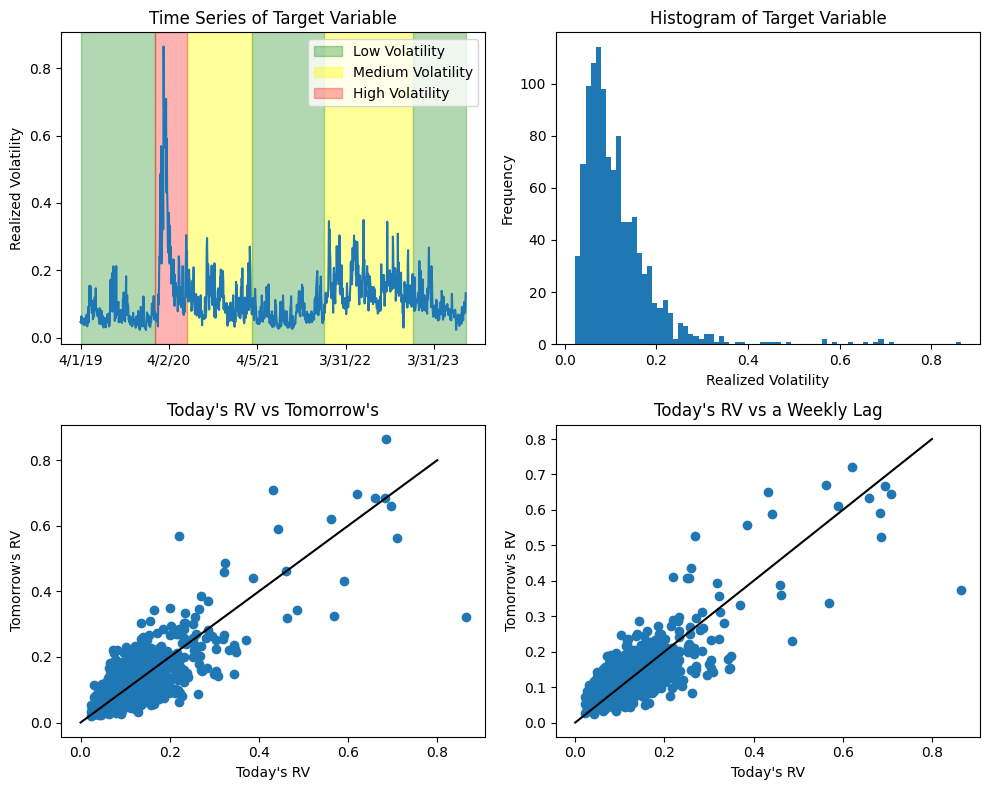

In [2]:
# Subjective, qualitative volatility region designations
low_vol_start_1, low_vol_end_1 = 0, 210
high_vol_start, high_vol_end = 210, 300
med_vol_start_1, med_vol_end_1 = 301, 484
low_vol_start_2, low_vol_end_2 = 485, 690
med_vol_start_2, med_vol_end_2 = 691, 939
low_vol_start_3, low_vol_end_3 = 940, 1091

#### ALL PLOTS ARE ON VOLATILITY SCALE ####
fig, ax = plt.subplots(2,2, figsize=(10,8))
# Time Series plot
ax[0,0].plot(data['date'], data['RV_t (Realized Variance)']**.5*(252)**.5)
ax[0,0].axvspan(low_vol_start_1, low_vol_end_1, color='green', alpha=0.3, label='Low Volatility')
ax[0,0].axvspan(med_vol_start_1, med_vol_end_1, color='yellow', alpha=0.4, label='Medium Volatility')
ax[0,0].axvspan(high_vol_start, high_vol_end, color='red', alpha=0.3, label='High Volatility')
ax[0,0].axvspan(low_vol_start_2, low_vol_end_2, color='green', alpha=0.3)
ax[0,0].axvspan(med_vol_start_2, med_vol_end_2, color='yellow', alpha=0.4)
ax[0,0].axvspan(low_vol_start_3, low_vol_end_3, color='green', alpha=0.3)
ax[0,0].legend()
ax[0,0].set_xticks(data['date'][::250])
ax[0,0].set_ylabel('Realized Volatility')
ax[0,0].set_title('Time Series of Target Variable')

# Histogram
ax[0,1].hist(data['RV_t (Realized Variance)']**.5*(252)**.5, bins=75)
ax[0,1].set_xlabel('Realized Volatility')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Histogram of Target Variable')

# Scatterplot 1
ax[1,0].scatter(data['RV_t (Realized Variance)']**.5*(252)**.5, data['RV_(t-1)']**.5*(252)**.5)
ax[1,0].plot([0,.8],[0,.8], color = 'k')
ax[1,0].set_xlabel("Today's RV")
ax[1,0].set_ylabel("Tomorrow's RV")
ax[1,0].set_title("Today's RV vs Tomorrow's")

# Scatterplot 2
ax[1,1].scatter(data['RV_t (Realized Variance)']**.5*(252)**.5, data['RV_t Weekly']**.5*(252)**.5)
ax[1,1].plot([0,.8],[0,.8], color = 'k')
ax[1,1].set_xlabel("Today's RV")
ax[1,1].set_ylabel("Tomorrow's RV")
ax[1,1].set_title("Today's RV vs a Weekly Lag")
fig.tight_layout()
plt.show()

##### From the time series, we notice that (over this period) volatility is generally in low or medium "regions", except for the start of the COVID pandemic. The histogram shows the highly skewed nature of volatility and reinforces the observation that volatility is generally low or moderate. From the two scatterplots, we see that there is a linear relationship between $RV_t$ and both $RV_{t-1}^d$ and $RV_{t-1}^w$. While not shown, the same is true for $RV_{t-1}^m$. This explains why the simple HAR model does well, since it is a linear combination of the RV lags. However, we still expect improvements from a more powerful model with a larger feature set.

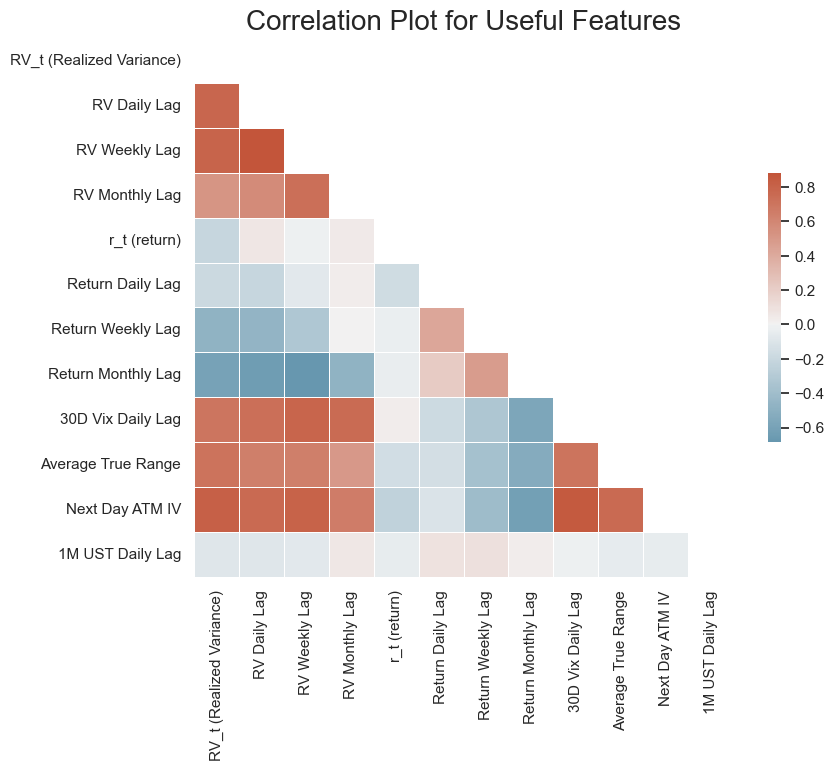

In [3]:
sns.set_theme(style="white")
# Drop features which are not used in the final model
corr = data.drop(
    ['date','AssetPrice', 'halfDay', 'NumOfDaysSinceLastTradingDay', 'is_friday', 'RV_(t-10)', 
                  'RV_(t-15)','-5c','-5p', '5c', '5p', 'VIX Weekly', 'VIX Monthly',
                  'RQ_t (Realized Quarticity)', 'RQ_(t-1)','RQ_t Weekly', 'RQ_t Monthly']
                  ,axis=1).corr()
# Rename features for clarity
names = {'avg_ATM_IV': 'Next Day ATM IV', 'ATR': 'Average True Range', 'VIX Close (t-1)': '30D Vix Daily Lag', 
        'RV_(t-1)': 'RV Daily Lag', 'r_t Monthly': 'Return Monthly Lag', 'RV_t Monthly': 'RV Monthly Lag',
        'r_t Weekly': 'Return Weekly Lag', 'RV_t Weekly': 'RV Weekly Lag', 'r_(t-1)': 'Return Daily Lag',
        'pchange 1MT_(t-1)': '1M UST Daily Lag', 'is_friday': 'Friday Indicator'}

# Apply the name change
for j in range(2): corr.rename(names, axis=j, inplace=True)

# Create lower diagonal corr plot
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Plot for Useful Features', fontsize=20)
plt.show()

##### Here, we notice that $RV_t$ is highly correlated with many of the useful features. The correlations are mostly positive except for return lags. We notice that the correlation is most strong for the daily and weekly RV lags, only the monthly return lag, and many of the exogenous features (VIX, ATR, ATM IV). These features also turn out to have the highest feature importance score, as shown later.

### **1.3 Rolling Window Model**

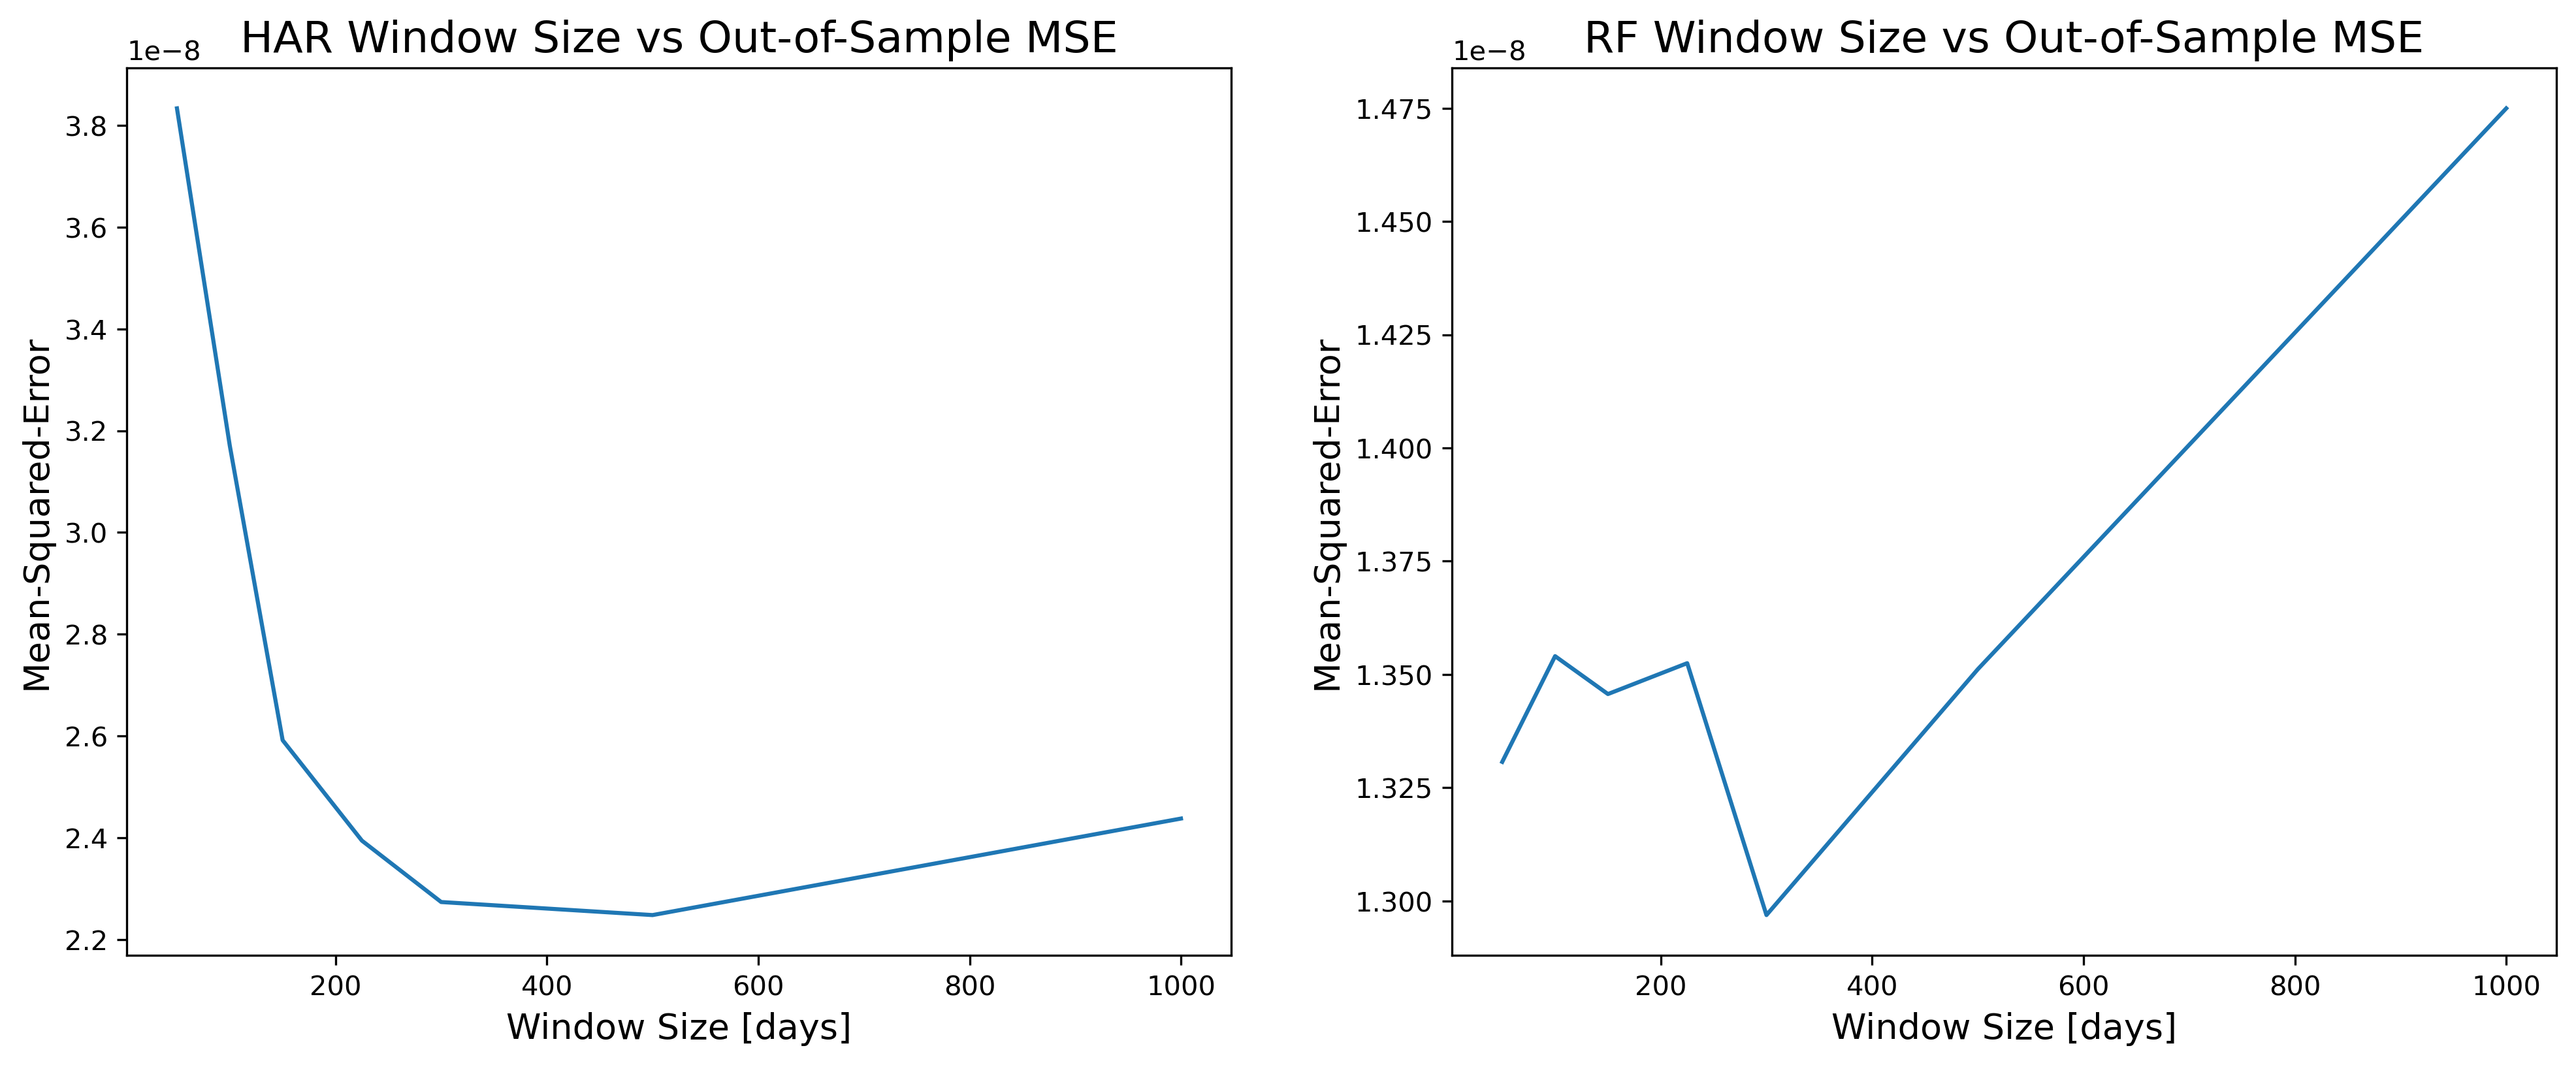

##### Market regimes consistently change over long periods of time, generally on the scale of months or years. As a result, it is useful to restrict the model's training data to the most recent history. This is done by refitting the model each day to the previous W days, which allows it to update to the "current" market regime. The length of the "rolling window" was optimized at 300 for both the Random Forest and HAR from data going back to 2001 (using only the autoregressive lags because of data availability). However, option data was limited (for the IV-based feature), so we chose a 150-day window the RF model to get 150 more obsevations.

## 2. Baseline Models

### **2.1 The HAR Model**

##### The HAR:
##### $RV_t = \beta_0 + \beta_1*RV_{t-1}^d + \beta_2*RV_{t-1}^w + \beta_3*RV_{t-1}^m$
##### is fit using a 300-day rolling window model and OLS. More extensive documentation is available in Functions/trading_strategy.py. Performance of alternative models will be based on their $R^2$ relative to the HAR:
##### Relative $R^2 = 1 - \frac{R_{model}^2}{R_{HAR}^2}$
### **All models are imported to save runtime.**

In [4]:
X_har = har_data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
Y_har = har_data['RV_t (Realized Variance)']

# HAR = RollingWindowHAR(X_har,Y_har,har_data['date'],w=300)
# dump(HAR, 'Data/Trained_Models/HAR.sav')
HAR = load('Data/Trained_Models/HAR.sav')
print(f"MSE of Basline HAR Model: {round(HAR['mse'],10)}")

MSE of Basline HAR Model: 1.86e-08


### **2.2 Baseline Random Forest Model**

##### The baseline Random Forest model, with only the three HAR features, is able to capture 12% more of the variance (has a 12% lower mean squared-error). See Functions/trading_strategy.py for more information on how the RF models are fit.

In [5]:
X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
Y = data['RV_t (Realized Variance)']

# RF_3f = RollingWindowRF(X,Y,data['date'],method = 'mse', n_trees=40,w=150)
# dump(RF_3f, 'Data/Trained_Models/RF_3f.sav')
RF_3f = load('Data/Trained_Models/RF_3f.sav')
print(f"RV Features Only R^2 relatve to HAR: {round(1 - RF_3f['mse']/(1.86e-8),3)}")

RV Features Only R^2 relatve to HAR: 0.124


## 3. Feature Selection for the Random Forest Model

### **3.1 Feature Selection**

##### Now, we successively add features and examine the effect on performance.

#### **Add Realied Quarticity Features**

##### Similar to how Realized Variance is a consistent estimator of Integrated Variance (the second moment of log returns), Realized Quarticity is a consistent estimator for the fourth moment of log returns and is often used in extentions of the HAR. However, we find that the daily, weekly, and monthly RQ lags do not improve model performance. Hence, we will not use them in any further models.

In [6]:
X = pd.concat([X,
               data[['RQ_(t-1)','RQ_t Weekly', 'RQ_t Monthly']]
          ], axis=1)

# RF_6f = RollingWindowRF(X,Y,data['date'],method = 'mse', n_trees=40,w=150)
# dump(RF_6f, 'Data/Trained_Models/RF_6f.sav')
RF_6f = load('Data/Trained_Models/RF_6f.sav')
print(f"RV and RQ Features Only R^2 relatve to HAR: {round(1 - RF_6f['mse']/(1.86e-8),3)}")

RV and RQ Features Only R^2 relatve to HAR: 0.125


#### **Add Return Features, Drop Quarticity Features**

##### Next, we add the daily, weekly, and monthly **return lags** to the RF model. These features are very useful, and increase the relative $R^2$ by more than a factor of two. Since variance is always positive, the return lags contain additional information based on the direction the market is moving.

In [7]:
X.drop(['RQ_(t-1)','RQ_t Weekly', 'RQ_t Monthly'], axis=1, inplace=True)
X = pd.concat([X,
               data[['r_(t-1)', 'r_t Weekly', 'r_t Monthly']]]
               , axis=1)

# RF_9f = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse')
# dump(RF_9f, 'Data/Trained_Models/RF_9f.sav')
RF_9f = load('Data/Trained_Models/RF_9f.sav')
print(f"RV, Return Features R^2 relatve to HAR: {round(1 - RF_9f['mse']/(1.86e-8),3)}")

RV, Return Features R^2 relatve to HAR: 0.265


#### **Add 30D VIX, 1M Treausry Yield, Friday Indicator**

##### We now add three exogenous inputs: the 30D VIX, the percent change of the 1M UST yield, and an indicator for Friday to account for the weekend. These features do not improve model performance on their own. However, their interaction with later features is important, as the VIX ends up as the third most important feature, so we keep them in the model.

In [8]:
X = pd.concat([X, 
          data[['VIX Close (t-1)', 'is_friday', 'pchange 1MT_(t-1)']]]
          ,axis=1)

# RF_some_exog_features = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse')
# dump(RF_some_exog_features, 'Data/Trained_Models/RF_some_exog_features.sav')
RF_some_exog_features = load('Data/Trained_Models/RF_some_exog_features.sav')
print(f"RV/RQ/Return + Some Exogenous Features R^2 relatve to HAR: {round(1 - RF_some_exog_features['mse']/(1.86e-8),3)}")

RV/RQ/Return + Some Exogenous Features R^2 relatve to HAR: 0.245


#### **Add Short Term ATM IV and Average True Range Technical Indicator Features**

##### Finally, we add two more exogenous features. The first is an estimate for short term at-the-money implied volatility, which incorporates market expectations about future volatility. This feature was constructed by taking an average of the implied volatility of the call strike above and put strike below the closing price of SPY for the previous day with closest expiry. Next-day expiry options are included once they become available in summer 2022. Average true range (ATR) is the average distance between SPY's high and low over a 14 day window and is used by traders as an indicator of volatility.  

##### Implied vol and ATR data were aquired using polygon.io and scraped individually. See Functions/polygon_scrape.py for more information.

##### These features were found to be very important, increasing the relative $R^2$ by almost another factor for two. Our final RF model is almost twice as effective as the HAR on a squared-error basis.

In [9]:
X = pd.concat([X, 
          data[['avg_ATM_IV', 'ATR']]]
          ,axis=1)

# RF_best = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse', SHAP=True)
# dump(RF_best, 'Data/Trained_Models/RF_best.sav')
RF_best = load('Data/Trained_Models/RF_best.sav')
print(f"Most Feature Model R^2 relatve to HAR: {round(1 - RF_best['mse']/(1.86e-8),3)}")

Most Feature Model R^2 relatve to HAR: 0.442


# TABLE OF RESULTS

### **3.2 Comparison vs HAR Results**

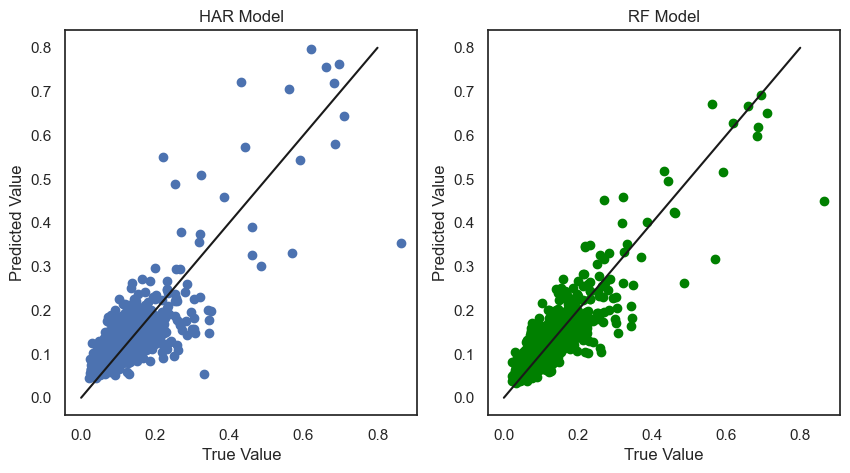

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, HAR['predictions'].T**.5*(252)**.5)
ax[0].plot([0,.8],[0,.8], color='k')
ax[0].set_title('HAR Model')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')


ax[1].scatter(data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, RF_best['predictions'].T**.5*(252)**.5, c='green')
ax[1].plot([0,.8],[0,.8], color='k')
ax[1].set_title('RF Model')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')

plt.show()

##### We see that the heteroskedasticity observed for HAR residuals is significantly reduced for the RF residuals. RF Predictions are more accurate at all volatility scales.

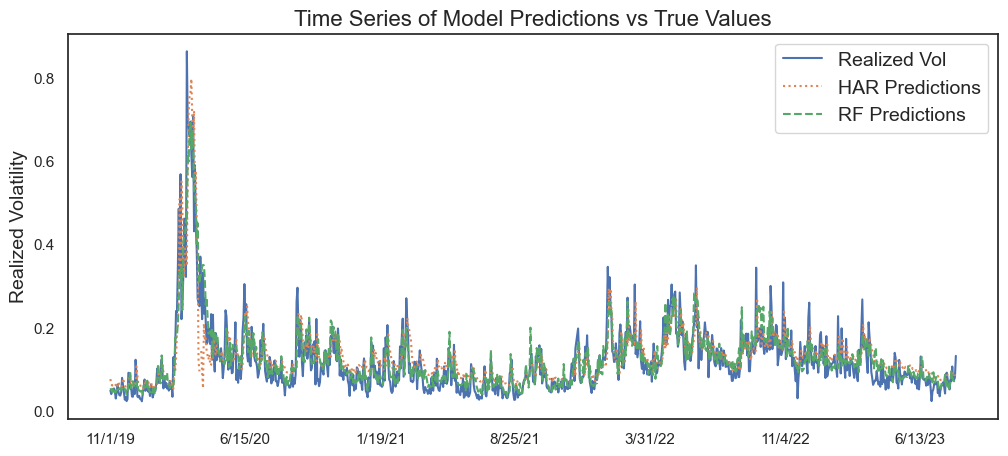

In [11]:
plt.figure(figsize=(12,5))
plt.plot(data['date'][150:], data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, label='Realized Vol')
plt.plot(data['date'][150:], HAR['predictions'].T**.5*(252)**.5, label='HAR Predictions', ls=':')
plt.plot(data['date'][150:], RF_best['predictions'].T**.5*(252)**.5, label='RF Predictions', ls='--')
plt.title('Time Series of Model Predictions vs True Values', fontsize=16)
plt.ylabel('Realized Volatility', fontsize=14)
plt.xticks(data['date'][150::150])
plt.legend(fontsize=14)
plt.show()

##### We see in the time series plot above that the HAR behaves more eradically during the COVID spike in early 2020, and that it many regions it consistently overpredicts. The RF predictions follow the trend much better. However, as expected, neither model is able to truely capture the seemingly random nature inherent to future volatility.

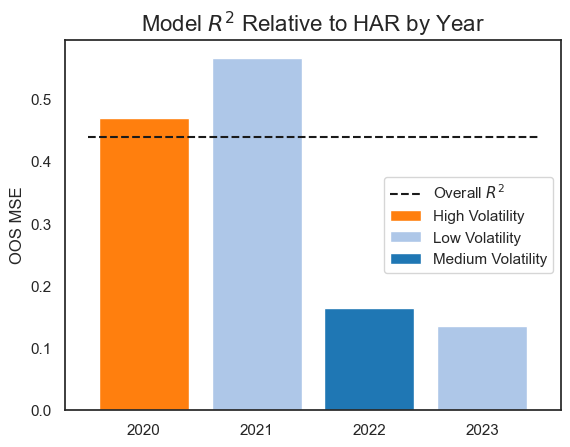

In [12]:
MSE_2020_RF = mean_squared_error(RF_best['predictions'].T.iloc[:290], data['RV_t (Realized Variance)'].iloc[150:440])
MSE_2021_RF = mean_squared_error(RF_best['predictions'].T.iloc[290:540], data['RV_t (Realized Variance)'].iloc[440:690])
MSE_2022_RF = mean_squared_error(RF_best['predictions'].T.iloc[540:789], data['RV_t (Realized Variance)'].iloc[690:939])
MSE_2023_RF = mean_squared_error(RF_best['predictions'].T.iloc[789:], data['RV_t (Realized Variance)'].iloc[939:])

MSE_2020_HAR = mean_squared_error(HAR['predictions'].T.iloc[:290], data['RV_t (Realized Variance)'].iloc[150:440])
MSE_2021_HAR = mean_squared_error(HAR['predictions'].T.iloc[290:540], data['RV_t (Realized Variance)'].iloc[440:690])
MSE_2022_HAR = mean_squared_error(HAR['predictions'].T.iloc[540:789], data['RV_t (Realized Variance)'].iloc[690:939])
MSE_2023_HAR = mean_squared_error(HAR['predictions'].T.iloc[789:], data['RV_t (Realized Variance)'].iloc[939:])

bar_heights = [1-MSE_2020_RF/MSE_2020_HAR, 1-MSE_2021_RF/MSE_2021_HAR, 1-MSE_2022_RF/MSE_2022_HAR, 1-MSE_2023_RF/MSE_2023_HAR]
years = [2020,2021,2022,2023]
colors = ['#ff7f0e', '#aec7e8', '#1f77b4','#aec7e8']
labels = ['High Volatility', 'Low Volatility', 'Medium Volatility']
for i in range(len(years)):
    plt.bar(years[i], bar_heights[i], color=colors[i], label=labels[i] if i < len(labels) else "")
plt.plot([2019.5,2023.5],[.44]*2, ls='--', color='k', label = 'Overall $R^2$')
plt.xticks([2020,2021,2022,2023])
plt.ylabel('OOS MSE')
plt.title('Model $R^2$ Relative to HAR by Year', fontsize=16)
plt.legend()
plt.show()

##### We see that the RF model performs best relative to the HAR during 2020 and 2021. It is likely that the HAR's continued poor performance in 2021, following a period of high volatility, results from overfitting to the large errors observed during the COVID spike. Since the random forest model required fewer training days, 150 vs 300, it adapted to the low volatility region faster than the HAR.

Note: Overall R^2 doesn't lineup since 2 extra months for 2022, 4 less months for 2023

### **3.3 Feature Importance**

##### For feature importance, we consider SHAP values instead of the popular mean impurity decrease metric for random forests. SHAP values are more powerful since they consider all possible feature combinations and evaluate the direct contribution of each input to the model's output. Importantly, the clever Kernel SHAP method is able to estimate SHAP values without fitting every possible feature permutation, allowing fast computation. Many studies have shown the superiority of SHAP values for "black box" model interpretability. See the widely cited paper *"A Unified Approach to Interpreting Model Predictions"* for more information.

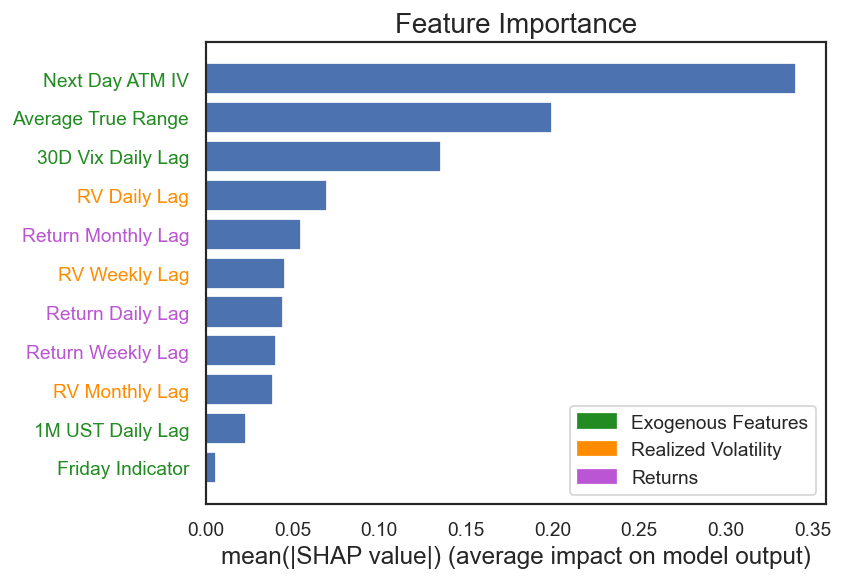

In [13]:
shap_values = RF_best['feature_importance'].T
abs_shap = abs(shap_values)
normalized_shap_values = abs_shap / np.linalg.norm(abs_shap, axis=1, keepdims=True, ord=1)

avg_normalized_shap = np.mean(normalized_shap_values,axis=0)
sorted_indices = sorted(range(len(avg_normalized_shap)), key=lambda i: avg_normalized_shap[i])

renamed_X = X[150:].rename({'avg_ATM_IV': 'Next Day ATM IV', 'ATR': 'Average True Range', 'VIX Close (t-1)': '30D Vix Daily Lag', 
                                               'RV_(t-1)': 'RV Daily Lag', 'r_t Monthly': 'Return Monthly Lag', 'RV_t Monthly': 'RV Monthly Lag',
                                               'r_t Weekly': 'Return Weekly Lag', 'RV_t Weekly': 'RV Weekly Lag', 'r_(t-1)': 'Return Daily Lag',
                                               'pchange 1MT_(t-1)': '1M UST Daily Lag', 'is_friday': 'Friday Indicator'}, axis=1)
sorted_columns = [renamed_X.columns[i] for i in sorted_indices]
sorted_shap = [avg_normalized_shap[i] for i in sorted_indices]

label_colors = {
    'Next Day ATM IV': 'forestgreen',
    'Average True Range': 'forestgreen',
    '30D Vix Daily Lag': 'forestgreen',
    '1M UST Daily Lag': 'forestgreen',
    'Friday Indicator': 'forestgreen',
    'RV Daily Lag': 'darkorange',
    'RV Weekly Lag': 'darkorange',
    'RV Monthly Lag': 'darkorange',
    'Return Daily Lag': 'mediumorchid',
    'Return Weekly Lag': 'mediumorchid',
    'Return Monthly Lag': 'mediumorchid'
}

plt.figure(dpi=125)
plt.barh(sorted_columns, sorted_shap)

plt.xlabel('mean(|SHAP value|) (average impact on model output)', fontsize=14)
plt.title('Feature Importance', fontsize=16)

for i, label in enumerate(plt.gca().get_yticklabels()):
    label_text = label.get_text()
    label.set_color(label_colors.get(label_text, 'black'))

import matplotlib.patches as mpatches
forestgreen_patch = mpatches.Patch(color='forestgreen', label='Exogenous Features')
darkorange_patch = mpatches.Patch(color='darkorange', label='Realized Volatility')
mediumorchid_patch = mpatches.Patch(color='mediumorchid', label='Returns')

plt.legend(handles=[forestgreen_patch, darkorange_patch, mediumorchid_patch], loc='best')

plt.show()

##### Figure 2 on the poster.
##### We see that three exogenous variables were responsible for about 65% of the model's output. As expected, the at-the-money implied volatility feature incorporated market expectations that are missing in the HAR. Under the efficient market hypothesis, at-the-money implied volatility should contain ALL available information regarding future volatility, which explains its importance for the model.

## 4. Hyperparameter Tuning

##### Up to this point, hyperparameters were chosen to create a flexible random forest. Important choices were 40 trees, all features available for each tree, max tree depth of 12, and a minimum of 2 samples required at a terminal node. The number of trees was set arbitrarily at about 25% of the training set size; not too high, to reduce computation time, but large enough to create a robust model. To increase model flexibility, each tree was allowed to use all features, which is not common for a Random Forest. This was done to capture interaction effects between features: if two or more features with important interactions are not often present in the same tree, important relationships could be missed. Thus, the model was similar to bagging where each tree trains on a random subset of the data. A low value for minimum samples required at a terminal node was chosen to allow to each tree to fit strongly to the training data, given that the inherent randomness of volatility makes it hard to overfit. A moderate value for max depth was chosen to restrict the trees from overfitting. We now examine other values for these parameters to ensure that the choices were reasonable.

In [57]:
rf_params = {
    'n_trees': [40, 80],
    'min_samples_leaf': [1,2,4,8],
    'max_depth': [6,12,18],
    'max_features': [int(len(X.columns)/2), len(X.columns)]}

# res = []
# for n in rf_params['n_trees']:
#     for msl in rf_params['min_samples_leaf']:
#         for md in rf_params['max_depth']:
#             for mf in rf_params['max_features']:
#                 model = RollingWindowRF(X,Y,dates=data['date'],w=150,md=md,n_trees=n, msl=msl, mf=mf)
#                 res.append(
#                     {'mse': model['mse'].round(10),
#                     'n_trees': n, 'min_samples_leaf': msl, 'max_depth': md, 'max_features': mf}
#                 )

# dump(res, 'Data/Trained_Models/grid_search_result.sav')
res = load('Data/Trained_Models/grid_search_result.sav')
res_df =pd.DataFrame(res)

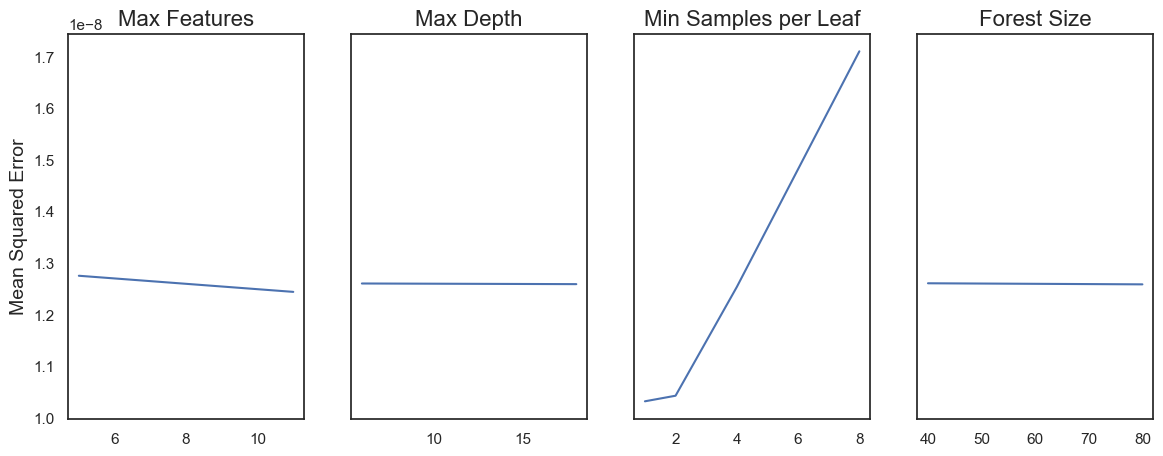

In [86]:
mf_res, md_res, msl_res, tree_res  = ([],[],[],[])

for mf in rf_params['max_features']:
    mf_res.append(
        res_df[res_df['max_features'] == mf]['mse'].mean()
        )
for md in rf_params['max_depth']:
    md_res.append(
        res_df[res_df['max_depth'] == md]['mse'].mean()
    )
for msl in rf_params['min_samples_leaf']:
    msl_res.append(
        res_df[res_df['min_samples_leaf'] == msl]['mse'].mean()
    )
for n in rf_params['n_trees']:
    tree_res.append(
        res_df[res_df['n_trees'] == n]['mse'].mean()
    )

fig, ax = plt.subplots(1,4,figsize=(14,5), sharey=True)
ax[0].plot(rf_params['max_features'],mf_res)
ax[0].set_title('Max Features', fontsize=16)
ax[0].set_ylabel('Mean Squared Error', fontsize=14)

ax[1].plot(rf_params['max_depth'], md_res)
ax[1].set_title('Max Depth', fontsize=16)

ax[2].plot(rf_params['min_samples_leaf'], msl_res)
ax[2].set_title('Min Samples per Leaf', fontsize=16)

ax[3].plot(rf_params['n_trees'], tree_res)
ax[3].set_title('Forest Size', fontsize=16)
plt.show()

##### We notice that max features and min samples required per terminal node were most important. Also, their optimal values agree with what was used to train the models. It is not surprising that forest size, past a certain threshold, is not important, given that the model was only ever trained on 150 days. Thus, a smaller forest was sufficient. The insignificance of max depth suggests that the model was not fitting deep trees even when it was allowed to, which indicates that the sample space was easy to partition.

## 5. Option Trading Strategy Application

### **5.1 Background**

##### While improvement by reduction of prediction error was obtained, we wanted to see how this would translate to a monetary scale. Thus, a trading strategy based on our prediction for next-day volatility was devised. An option contract is an agreement between a buyer and a seller that gives the buyer the right, but not the obligation, to buy or sell an asset at a predetermined price before (or on) a certain date. The trading strategy uses both call (right to buy) and put (right to sell) options to construct a "strangle," which allows traders to take a position based on whether they predict high or low volatility: 

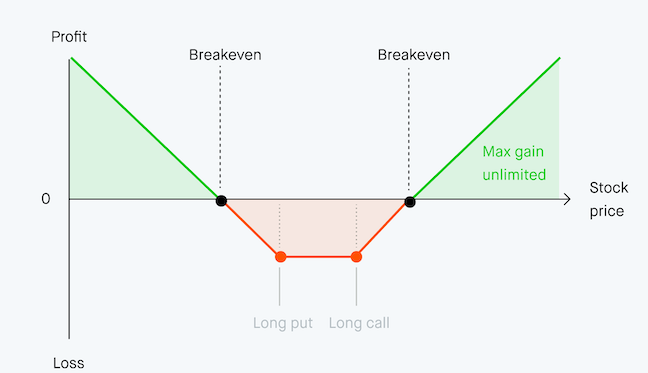

##### A trader will buy a strangle when they expect high volatility, and sell it when they expect calm. To compare our estimate to the "market's estimate", we used the price of the call strike just above and put strike just below SPY's closing price (with next day expiry) to dermine their average implied volatility: how much volatility the market has priced in. Since implied (projected) volatility is consistently higher than realized (observed) volatility, we normalize our estimate and the market's to their historical average. If the model predicts higher volatility than is priced in, we buy the strange for that day, and vice versa.   

In [15]:
# Import trading days package. Used in Functions/trading_strategy.py
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
start_date = '2019-01-01'
end_date = '2023-12-31'
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule['market_open'].dt.date.tolist()

In [16]:
# Import prediction data
strategy_return_data = pd.read_csv('Data/option_strategy_return_data.csv',index_col=0)
RF_predictions = pd.read_csv('Data/RF_Best_Model_Predictions.csv', index_col=0)
HAR_predictions = pd.read_csv('Data/HAR_Predictions.csv', index_col=0)
dates = dates = pd.Series(RF_predictions.index)
NN_predictions = pd.read_csv('Data/Neural_Net_Predictions.csv', index_col=0).drop(['TRUE', 'rf'], axis=1).rename({'nn_pred': 
                                                                                                                  'values'},axis=1)

### **5.2 Trading Strategy Results**

##### To measure performance, we independently invest $100 every day to buy or sell the strategy based on how our prediction compares to the market's expectation: "cumulative returns" meaures the sum of daily PnL. Cumulative returns could be improved by devising a position sizing strategy based on recent performance (since there are prolonged stretches of wins and losses) or by considering the size of the difference between the predictions. We will compare the performance of predictions from the HAR, a neural network constructed by a peer, our random forest, and a control strategy. Selling the strategy every day is a control since it is profitable.

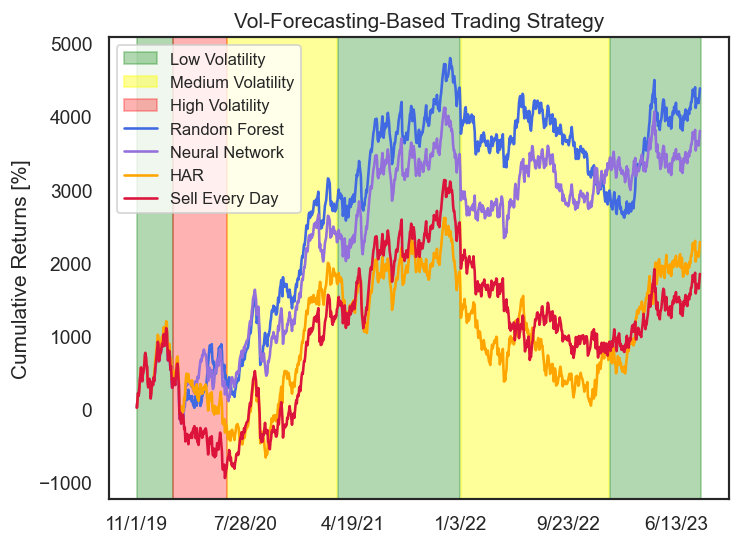

In [99]:
# Run the strategy using historical data -- see Functions/trading_strategy.py for more information
[strategy_result_RF,strategy_return_time_series_RF] = RunStrategy(RF_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)
[strategy_result_HAR,strategy_return_time_series_HAR] = RunStrategy(HAR_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)
[strategy_result_NN,strategy_return_time_series_NN] = RunStrategy(NN_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)

# Shade regions to indicate volatlity level
low_vol_start_1, low_vol_end_1 = 0, 60
high_vol_start, high_vol_end = 60, 150
med_vol_start_1, med_vol_end_1 = 151, 334
low_vol_start_2, low_vol_end_2 = 335, 540
med_vol_start_2, med_vol_end_2 = 541, 789
low_vol_start_3, low_vol_end_3 = 790, 941

fig, ax = plt.subplots(dpi=125)

# Shade volatility regions
ax.axvspan(low_vol_start_1, low_vol_end_1, color='green', alpha=0.3, label='Low Volatility')
ax.axvspan(med_vol_start_1, med_vol_end_1, color='yellow', alpha=0.4, label='Medium Volatility')
ax.axvspan(high_vol_start, high_vol_end, color='red', alpha=0.3, label='High Volatility')
ax.axvspan(low_vol_start_2, low_vol_end_2, color='green', alpha=0.3)
ax.axvspan(med_vol_start_2, med_vol_end_2, color='yellow', alpha=0.4)
ax.axvspan(low_vol_start_3, low_vol_end_3, color='green', alpha=0.3)

plt.plot(strategy_return_time_series_RF, label='Random Forest', c='royalblue')
plt.plot(strategy_return_time_series_NN, label='Neural Network', c='mediumpurple')
plt.plot(strategy_return_time_series_HAR, label='HAR', c='orange')
plt.plot(strategy_return_data['Return [%]'].cumsum()*-1, label = 'Sell Every Day', c='crimson')
plt.legend(fontsize=9.5)
plt.xticks(dates[::180])
plt.title('Vol-Forecasting-Based Trading Strategy')
plt.ylabel('Cumulative Returns [%]')
plt.show()

In [105]:
strategy_metrics_HAR = {'Total Return [%]': strategy_return_time_series_HAR[-1], 'Average Daily Return [%]': strategy_return_time_series_HAR[-1]/ len(strategy_return_time_series_RF)}
strategy_metrics_nn = {'Total Return [%]': strategy_return_time_series_NN[-1], 'Average Daily Return [%]': strategy_return_time_series_NN[-1]/ len(strategy_return_time_series_RF)}
strategy_metrics_rf = {'Total Return [%]': strategy_return_time_series_RF[-1], 'Average Daily Return [%]': strategy_return_time_series_RF[-1]/ len(strategy_return_time_series_RF)}
strategy_metrics_control = {'Total Return [%]': strategy_return_data['Return [%]'].cumsum()[-1]*-1, 'Average Daily Return [%]': strategy_return_data['Return [%]'].cumsum()[-1]*-1/ len(strategy_return_time_series_RF)}
pd.DataFrame([strategy_metrics_HAR, strategy_metrics_nn, strategy_metrics_rf, strategy_metrics_control], index = ['HAR', 'NN', 'RF', 'Control']).round(2)

,Total Return [%],Average Daily Return [%]
HAR,2284.96,2.43
NN,3802.08,4.04
RF,4383.06,4.66
Control,1849.78,1.97


##### Based on total return, the neural network and random forest predictions significiantly outperform the HAR and control. All the strategies should have the same standard deviation since the absolute value of daily returns were identical, so they have identical "risk". From the trading strategy application, we observe the monetary implications of a model with 44% lower squared error.

### **5.3 Important Metrics**

##### While the returns of the trading strategy are impressive, this does not provide a comprehensive view of its performance. The most problematic aspect of the strategy is its high variance and the possibility of large losses: when the strategy is sold, which is most often the case, there are unbounded losses. Hence, a potential improvement would be to cap losses when the strategy is sold by also selling a low strike put and high strike call. Here we will explore other metrics that are used to evaluate a trading strategy. From now on, all results correspond to the random forest-based strategy.

##### **High Variance and Heavy Tails**

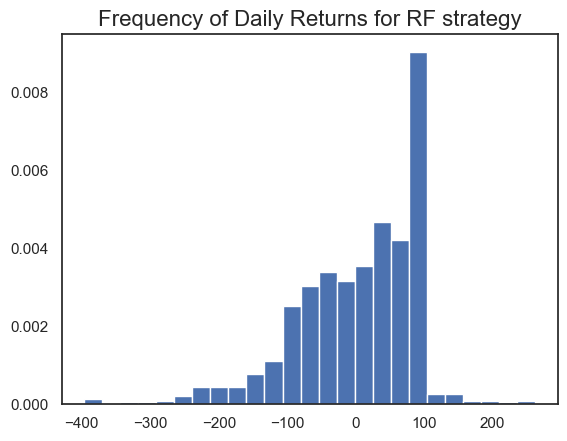

In [112]:
plt.hist([r['Return'] for r in strategy_result_RF], bins=25, density=True)
plt.title('Frequency of Daily Returns for RF strategy', fontsize=16)
plt.show()

##### The most frequent outcome was a 100% return: this corresponds to when the strategy was sold and the full premium was collected. The worst result was an almost -400% return, which occured three times scattered throughout the period. Surprisingly, there was not a huge loss on March 12, 2020, which had the highest realized volatility in the dataset. This was likely because the previous day, while not nearly as volatile, had an average ATM implied volatility of 115% at close. This allowed the model to predict very high volatility for the next day.

##### **Sortino Ratio**

##### The sortino ratio is similar to the popular sharpe ratio, which provides information about an asset or strategy's risk/return tradeoff. Both ratios are defined as: 
### $\frac{r - r_{rf}}{\sigma}$ 
##### where r is the return, $r_{rf}$ is the risk free rate of return, and $\sigma$ is the variance of returns. The difference between the ratios is that the sortio ratio only considers "downside" variance, that is the variance of negative returns. For option trading strategies, the downside variance is considered more important.

In [108]:
rs = [d['Return'] for d in strategy_result_RF]
neg_rs = [d for d in rs if d<0]
sortino_ratio = np.mean(rs) / np.std(neg_rs) * np.sqrt(252)
round(sortino_ratio,3)

1.103

##### The observed sortino ratio of 1.10 is above the "minimum" acceptable cutoff of 1, but is not incredible

- sortino ratio
- max drawdown
- CVAR

In [19]:
np.cov(pd.Series(strategy_return_time_series_RF).diff().dropna(), (1 - np.exp(data['r_t (return)'][150:].reset_index(drop=True)))[1:] *100)/ np.var((1 - np.exp(data['r_t (return)'][150:].reset_index(drop=True))[1:])*100)

array([[ 3.72889969e+03, -2.46267777e+00],
       [-2.46267777e+00,  1.00106496e+00]])

In [20]:
# Find Beta
import statsmodels.api as sm

X_beta = sm.add_constant((1 - np.exp(data['r_t (return)'][150:].reset_index(drop=True)))*100)  # Adds a constant term to the predictor
model = sm.OLS(pd.Series(strategy_return_time_series_RF).diff().dropna(), X_beta[1:]).fit()

# The slope (beta) is the coefficient of the market returns
beta = model.params[1]

print(f"Beta: {beta}")
print(model.summary())

Beta: -2.4600579047446463
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.526
Date:                Thu, 28 Mar 2024   Prob (F-statistic):              0.217
Time:                        15:45:23   Log-Likelihood:                -5552.1
No. Observations:                 940   AIC:                         1.111e+04
Df Residuals:                     938   BIC:                         1.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.512

## 6. Conclusions